Reading brent_prices.csv ...


C:\Users\Hp\AppData\Local\Temp\ipykernel_8504\3194808165.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)


Shape: (9011, 1)
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
            Price
Date             
2022-11-10  94.25
2022-11-11  96.37
2022-11-14  93.59

Price column name → Price


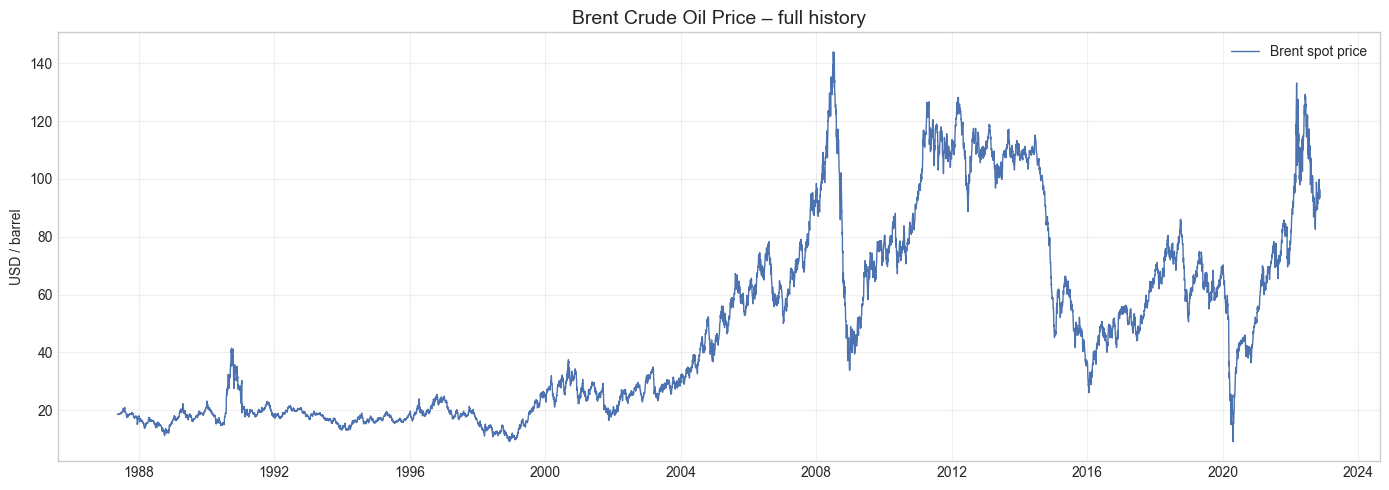

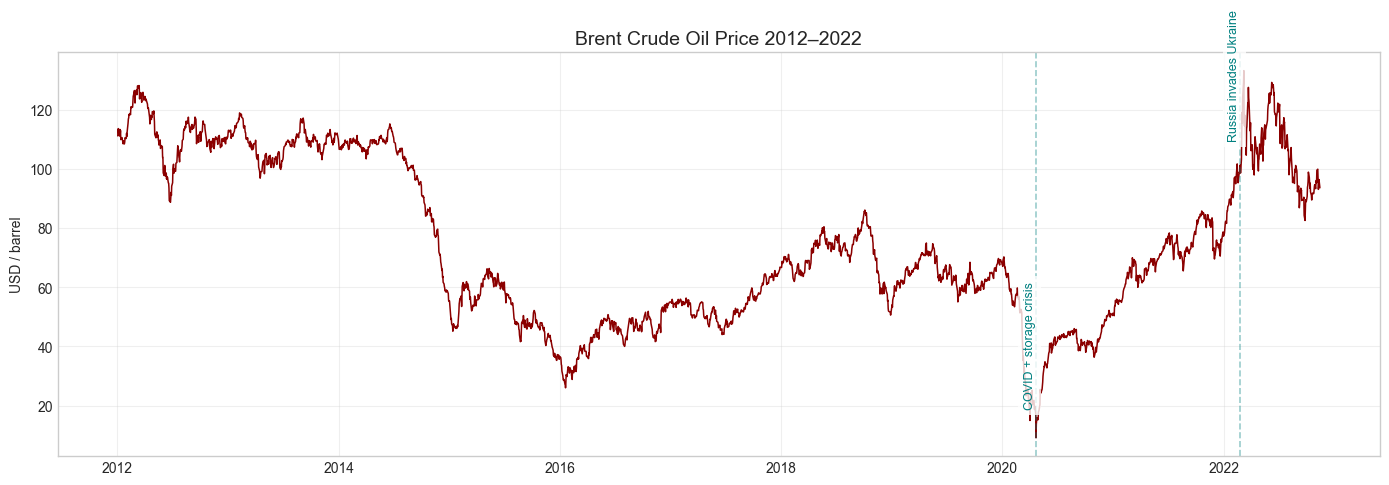

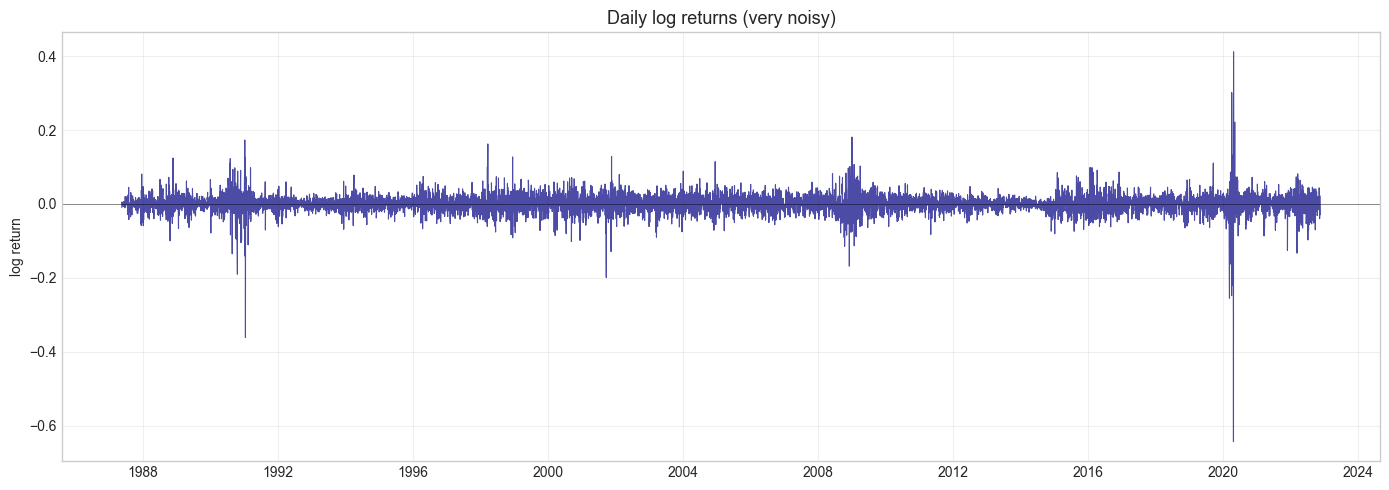

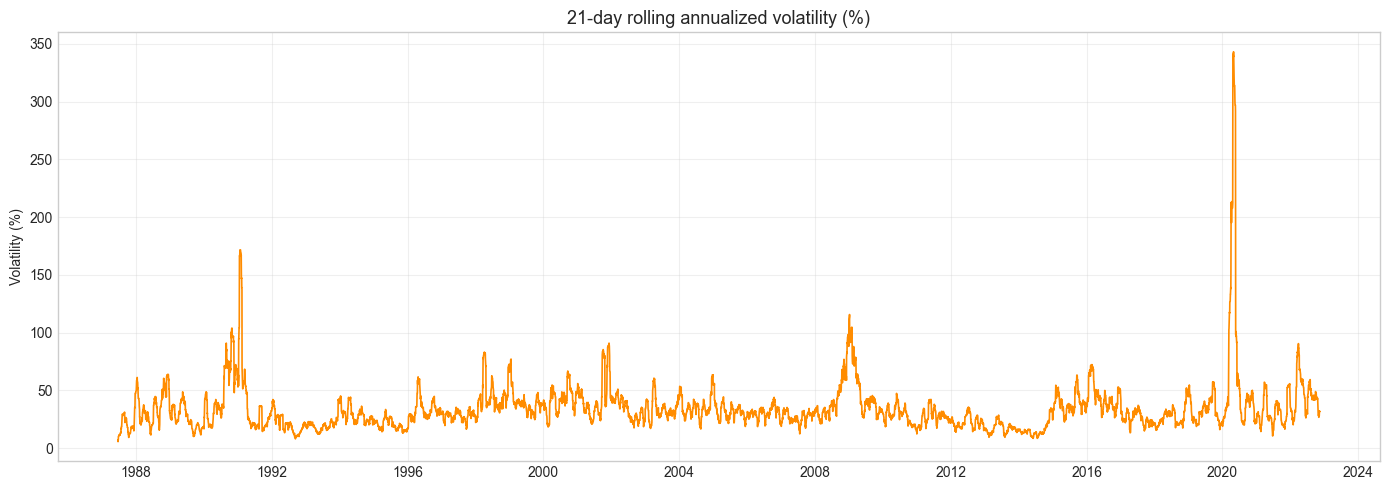


Basic statistics of log returns:
count    9010.000000
mean        0.000179
std         0.025532
min        -0.643699
1%         -0.063274
5%         -0.036385
25%        -0.011154
50%         0.000402
75%         0.012127
95%         0.035211
99%         0.063555
max         0.412023
Name: log_return, dtype: float64


In [4]:
# ────────────────────────────────────────────────────────────────
# 00_EDA.ipynb
# Basic look at the Brent crude oil price data
# ────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# ─── Load data ──────────────────────────────────────────────────────
print("Reading brent_prices.csv ...")
df = pd.read_csv("../data/raw/brent_prices.csv")

# Try to parse the date column (common formats people use)
possible_date_cols = ["Date", "date", "Day", "day", "Datetime"]
date_col = next((c for c in possible_date_cols if c in df.columns), None)

if date_col is None:
    print("Cannot find date column. Columns are:", df.columns.tolist())
    raise ValueError("No date column found")

df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

price_col = next((c for c in ["Price", "price", "Brent", "Close"] if c in df.columns), None)
if price_col is None:
    raise ValueError("No price column found. Columns:", df.columns.tolist())

print("Shape:", df.shape)
print(df.head(3))
print(df.tail(3))
print("\nPrice column name →", price_col)

# ─── Basic plots ────────────────────────────────────────────────────
plt.figure(figsize=(14, 5))
plt.plot(df.index, df[price_col], lw=1, label="Brent spot price")
plt.title("Brent Crude Oil Price – full history", fontsize=14)
plt.ylabel("USD / barrel")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Zoom last 10 years
plt.figure(figsize=(14, 5))
mask = df.index >= "2012-01-01"
plt.plot(df.index[mask], df[price_col][mask], color="darkred", lw=1.1)
plt.title("Brent Crude Oil Price 2012–2022", fontsize=14)
plt.ylabel("USD / barrel")

# Some famous events (you can expand this list)
events = {
    "2014-11-27": "OPEC no-cut → price war",
    "2020-04-20": "COVID + storage crisis",
    "2022-02-24": "Russia invades Ukraine",
}
for date_str, label in events.items():
    try:
        dt = pd.to_datetime(date_str)
        if dt in df.index or dt.date() in df.index.date:
            price = df.loc[dt, price_col] if dt in df.index else df[price_col].asof(dt)
            plt.axvline(dt, color="teal", alpha=0.4, ls="--", lw=1.2)
            plt.text(dt, price*1.08, label, rotation=90, va="bottom", ha="right",
                     fontsize=9, color="teal", bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))
    except:
        pass

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ─── Log returns ────────────────────────────────────────────────────
df["log_price"] = np.log(df[price_col])
df["log_return"] = df["log_price"].diff()

plt.figure(figsize=(14, 5))
plt.plot(df.index[1:], df["log_return"][1:], lw=0.8, color="navy", alpha=0.7)
plt.title("Daily log returns (very noisy)", fontsize=13)
plt.ylabel("log return")
plt.axhline(0, color="black", lw=0.6, alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Rolling volatility (21-day)
vol = df["log_return"].rolling(21).std() * np.sqrt(252) * 100   # annualized %

plt.figure(figsize=(14, 5))
plt.plot(vol.index, vol, color="darkorange", lw=1.2)
plt.title("21-day rolling annualized volatility (%)", fontsize=13)
plt.ylabel("Volatility (%)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nBasic statistics of log returns:")
print(df["log_return"].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))